   YearStart  YearEnd LocationAbbr   LocationDesc DataSource ConditionType  \
0       2015     2019           WV  West Virginia       ARDI       Chronic   
1       2015     2019           WV  West Virginia       ARDI         Total   
2       2015     2019           US  United States       ARDI         Acute   
3       2015     2019           US  United States       ARDI         Acute   
4       2015     2019           WV  West Virginia       ARDI         Acute   

                     Category        Cause_of_Death  \
0                       Total  Total for All Causes   
1                       Total  Total for All Causes   
2  Alcohol-Related Poisonings     Alcohol poisoning   
3  Alcohol-Related Poisonings     Alcohol poisoning   
4                       Total  Total for All Causes   

               Data_Value_Unit  Data_Value_Type  ... ConditionTypeID  \
0  Alcohol-attributable deaths  5 years average  ...          EXCSVE   
1  Alcohol-attributable deaths  5 years average  ...    

C:\Users\adedi\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


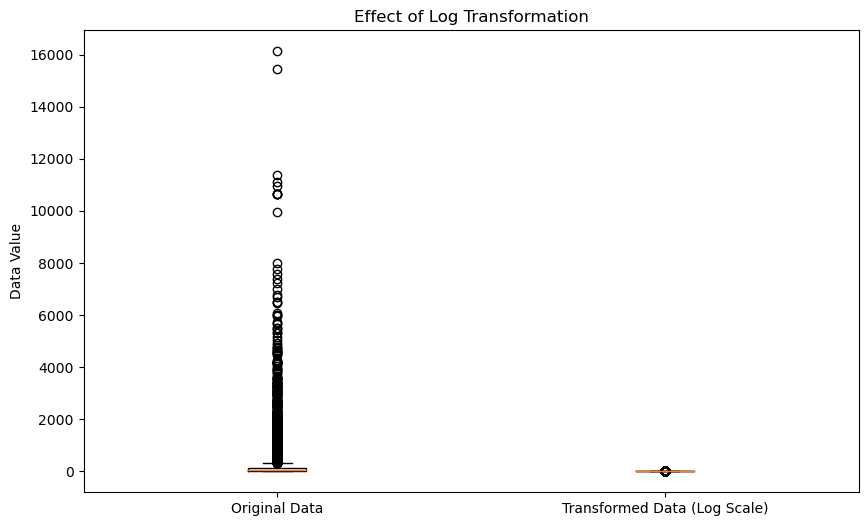

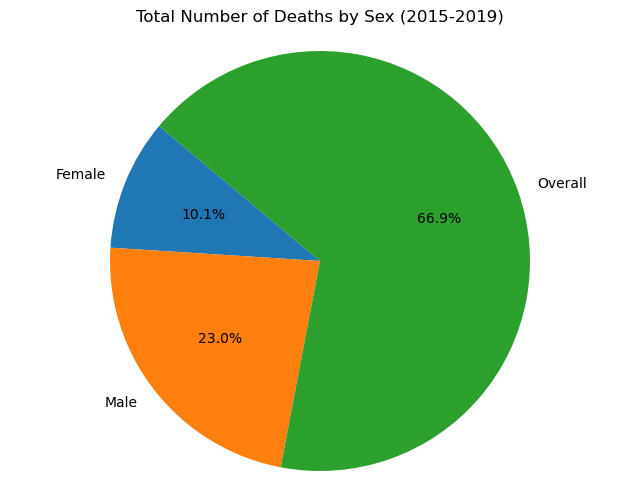

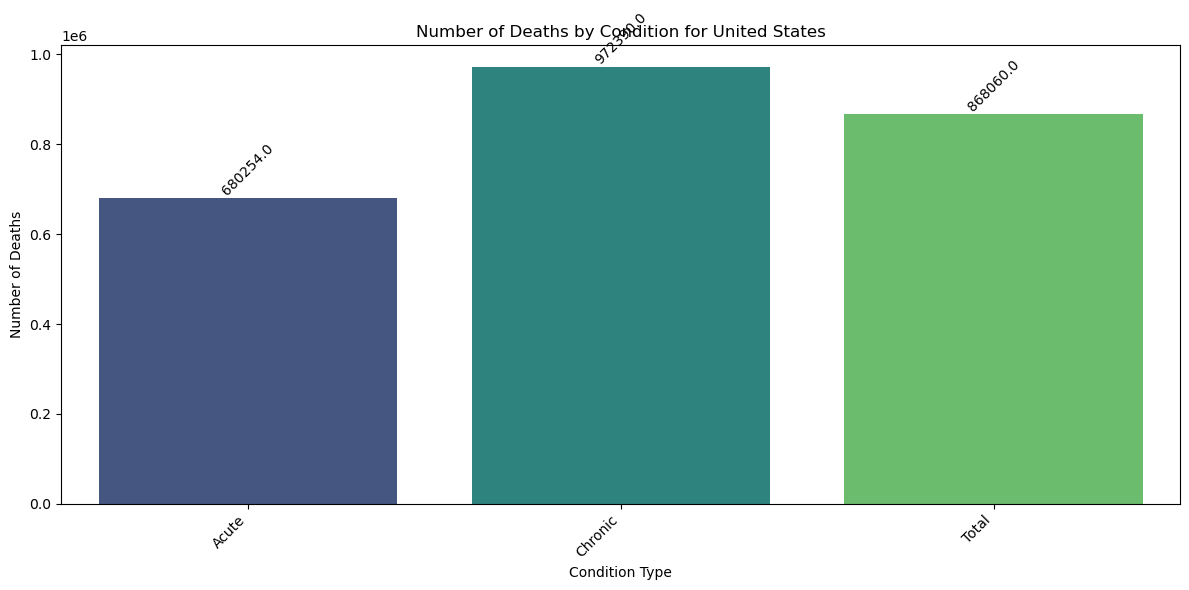

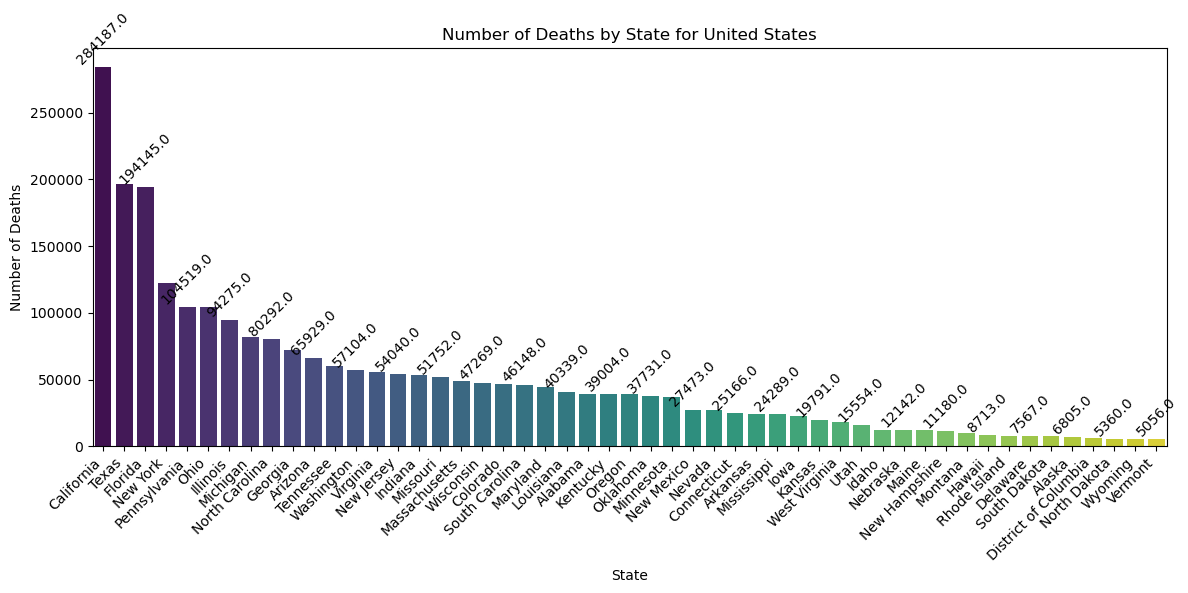

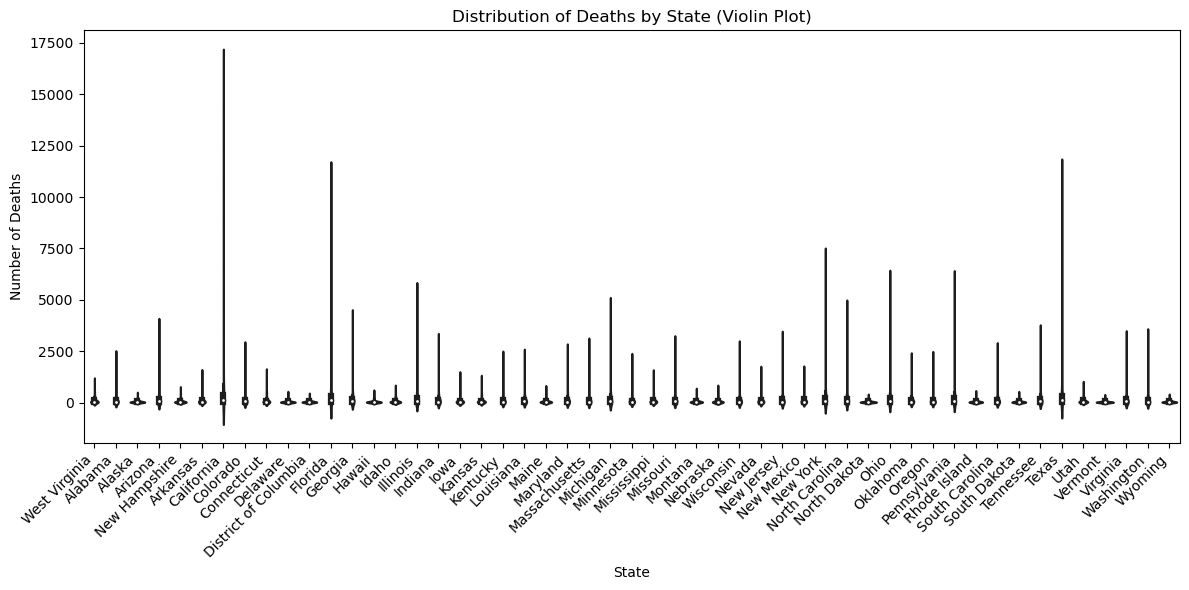

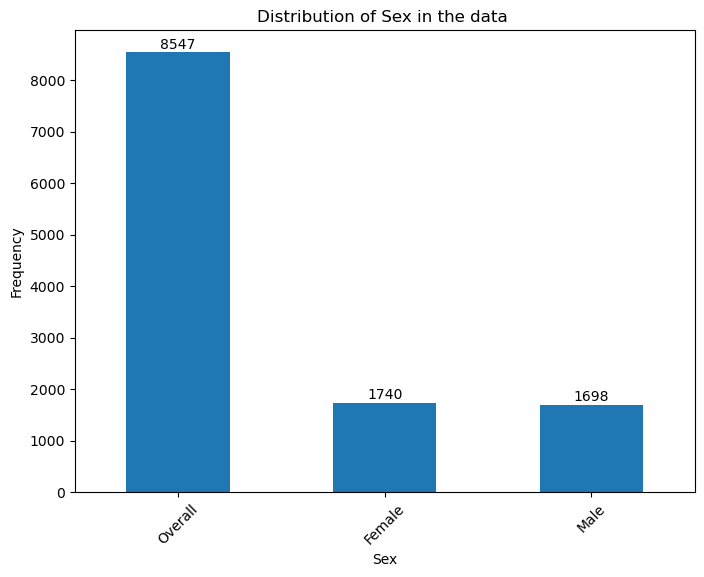

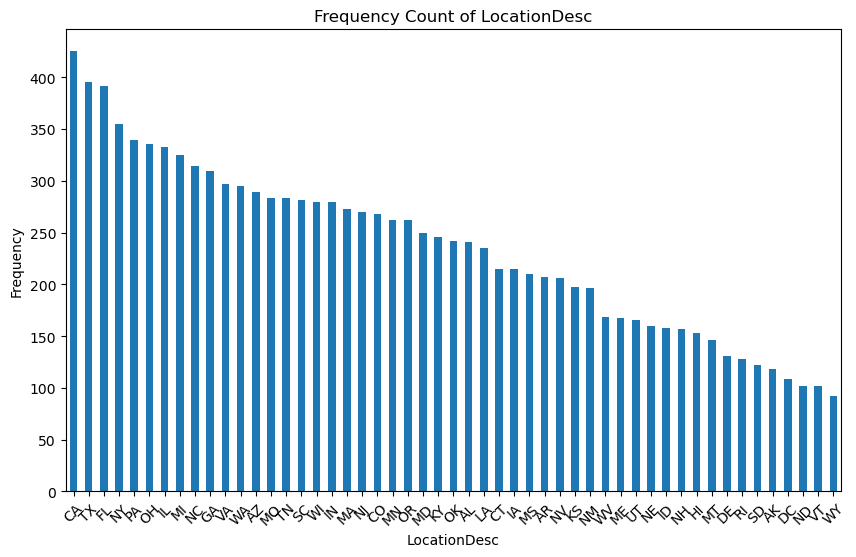

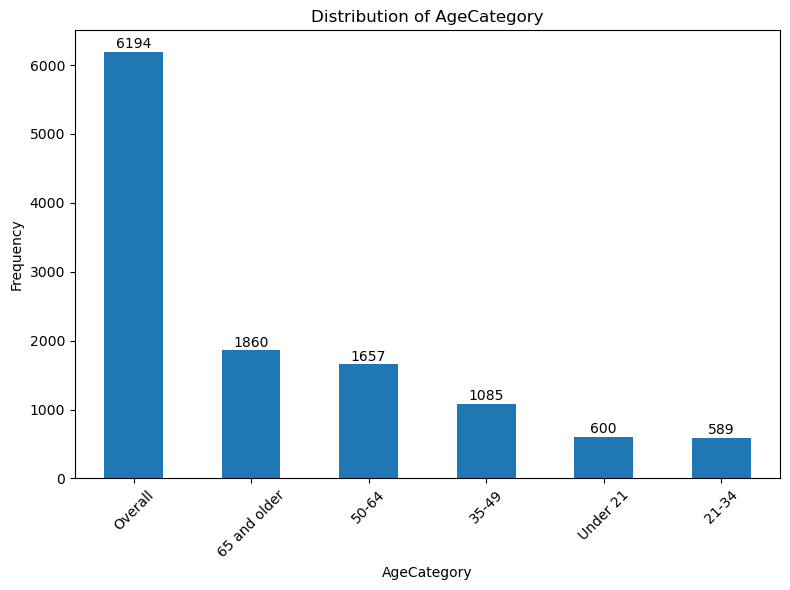

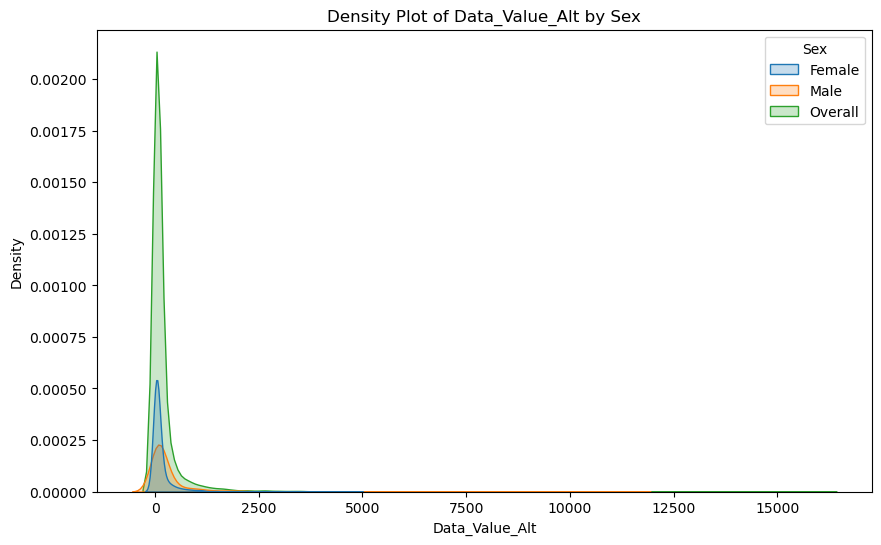

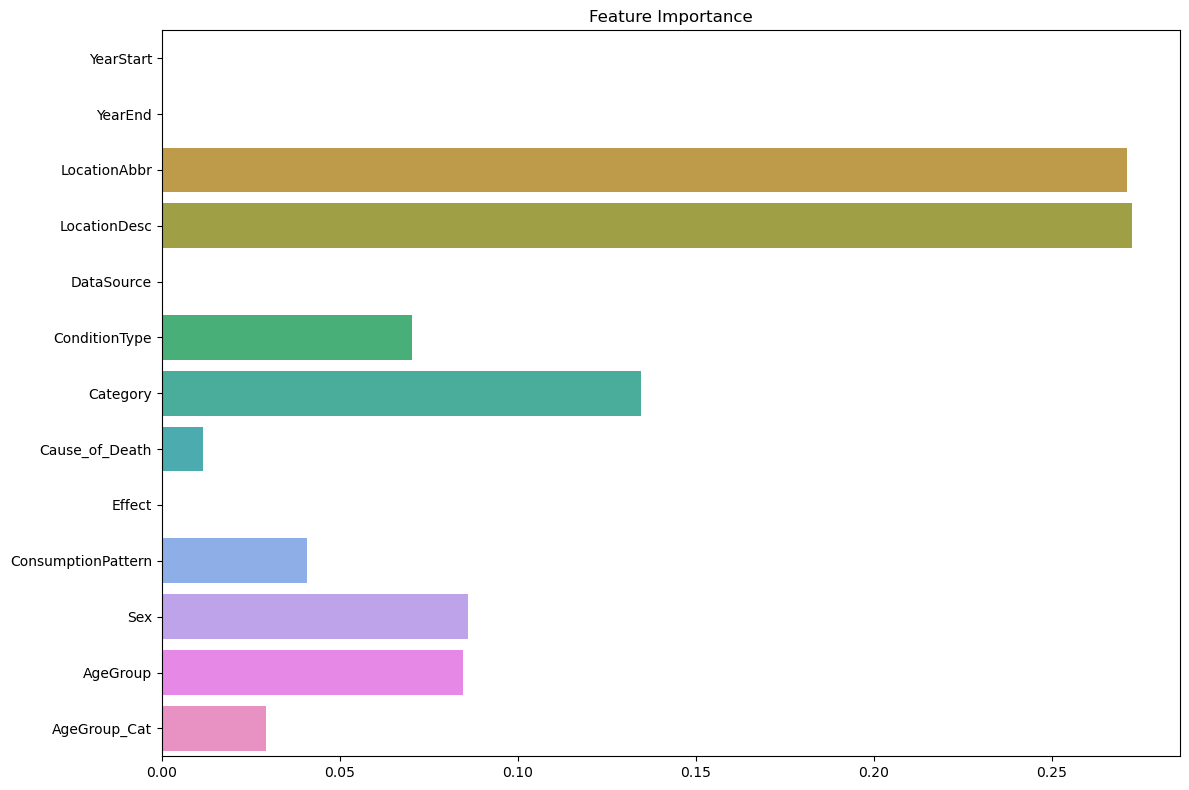

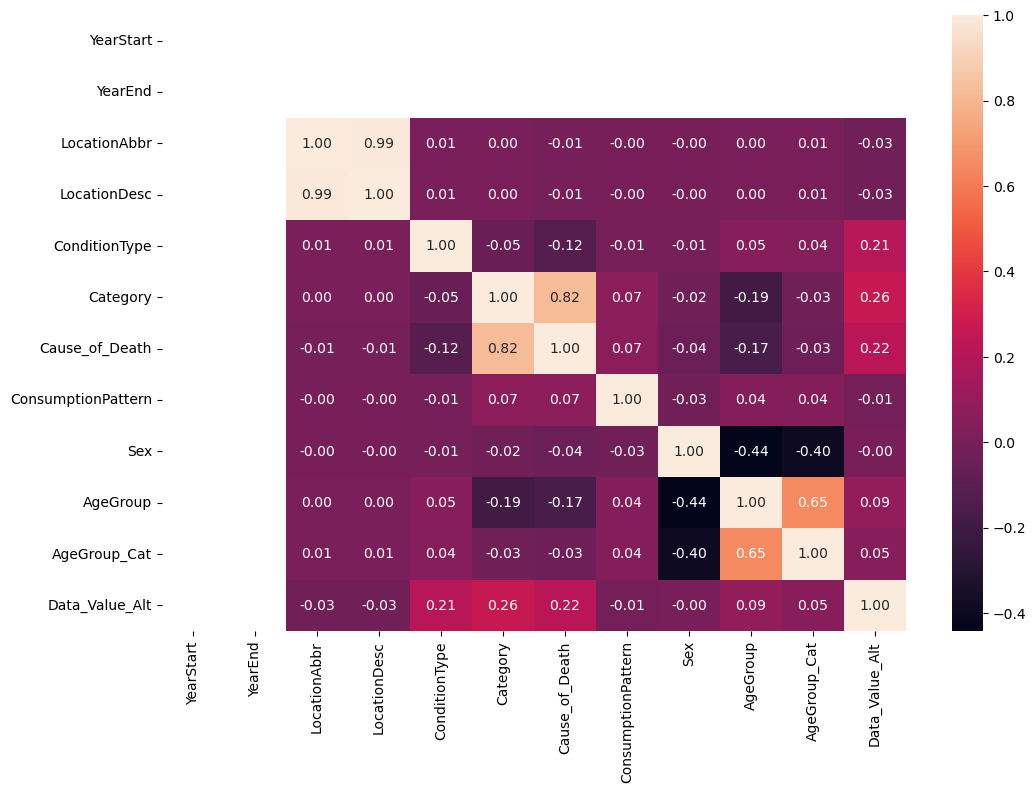

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Read the CSV file into a DataFrame
ardi_data = pd.read_csv('Alcohol-Related_Disease_Impact__ARDI__Application_-_Alcohol-Attributable_Deaths_20240217.csv')

# Display the first few rows of the DataFrame
print(ardi_data.head())

# Display the shape of the DataFrame
print(ardi_data.shape)

# Display the types of the columns
print(ardi_data.info())

# Check for missing values
missing_values = ardi_data.isnull().sum()
print(missing_values)

# Check for zero values in the 'Data_Value_Alt' column
zero_values = ardi_data[ardi_data['Data_Value_Alt'] == 0]
print("Rows with zero values:")
print(zero_values)

# Check for negative values in the 'Data_Value_Alt' column
negative_values = ardi_data[ardi_data['Data_Value_Alt'] < 0]
print("Rows with negative values:")
print(negative_values)

# Drop rows with negative values
ardi_data = ardi_data[ardi_data['Data_Value_Alt'] >= 0]

# Drop rows with empty cells (NaN or None) in the 'Data_Value_Alt' column
ardi_data = ardi_data.dropna(subset=['Data_Value_Alt'])

# Convert 'YearStart' and 'YearEnd' to years only
ardi_data['YearStart'] = pd.to_datetime(ardi_data['YearStart'], format='%Y').dt.year
ardi_data['YearEnd'] = pd.to_datetime(ardi_data['YearEnd'], format='%Y').dt.year

# Map age groups to categories
age_group_mapping = {
    'Under 21': 'Under 21',
    '0-19': 'Under 21',
    '20-34': '21-34',
    '35-49': '35-49',
    '50-64': '50-64',
    '65+': '65 and older',
    'Overall': 'Overall'
}
ardi_data['AgeGroup_Cat'] = ardi_data['AgeGroup'].map(age_group_mapping)

# Drop unnecessary columns and rows
ardi_data_cleaned = ardi_data[['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource', 'ConditionType',
                               'Category', 'Cause_of_Death', 'Effect', 'ConsumptionPattern', 'Sex', 'AgeGroup',
                               'AgeGroup_Cat','Data_Value_Alt']]
ardi_data_cleaned = ardi_data_cleaned[ardi_data_cleaned['LocationDesc'] != 'United States']

# Save cleaned data to a new CSV file
ardi_data_cleaned.to_csv("Cleaned_1_data.csv", index=False)

# Log transformation for right-skewed data
transformed_data = np.log(ardi_data_cleaned['Data_Value_Alt'])

# Plot boxplots for original and transformed data
plt.figure(figsize=(10, 6))
plt.boxplot([ardi_data_cleaned['Data_Value_Alt'], transformed_data], labels=['Original Data', 'Transformed Data (Log Scale)'])
plt.title('Effect of Log Transformation')
plt.ylabel('Data Value')
plt.show()

# Total number of deaths by sex
total_deaths_by_sex = ardi_data_cleaned.groupby('Sex')['Data_Value_Alt'].sum()

# Pie chart for total number of deaths by sex
plt.figure(figsize=(8, 6))
plt.pie(total_deaths_by_sex, labels=total_deaths_by_sex.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Number of Deaths by Sex (2015-2019)')
plt.axis('equal')
plt.show()

# Total number of deaths by condition type
total_deaths_by_type = ardi_data_cleaned.groupby('ConditionType')['Data_Value_Alt'].sum().reset_index()

# Bar plot for number of deaths by condition
plt.figure(figsize=(12, 6))
sns.barplot(x='ConditionType', y='Data_Value_Alt', data=total_deaths_by_type, palette='viridis')
plt.title('Number of Deaths by Condition for United States')
plt.xlabel('Condition Type')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45, ha='right')
for i, (condition, total) in enumerate(zip(total_deaths_by_type['ConditionType'], total_deaths_by_type['Data_Value_Alt'])):
    plt.text(i, total + 10, str(round(total, 2)), ha='center', va='bottom', rotation=45)
plt.tight_layout()
plt.show()

# Total number of deaths by state
deaths_by_state = ardi_data_cleaned.groupby('LocationDesc')['Data_Value_Alt'].sum().reset_index()
deaths_by_state = deaths_by_state[deaths_by_state['LocationDesc'] != 'United States']
deaths_by_state = deaths_by_state.sort_values(by='Data_Value_Alt', ascending=False)

# Bar plot for number of deaths by state
plt.figure(figsize=(12, 6))
sns.barplot(x='LocationDesc', y='Data_Value_Alt', data=deaths_by_state, palette='viridis')
plt.title('Number of Deaths by State for United States')
plt.xlabel('State')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45, ha='right')
for i in range(0, len(deaths_by_state), 2):
    plt.text(i, deaths_by_state.iloc[i]['Data_Value_Alt'] + 10, str(deaths_by_state.iloc[i]['Data_Value_Alt']), ha='center', va='bottom', rotation=45)
plt.tight_layout()
plt.show()

# Violin Plot for Distribution of Deaths by State
plt.figure(figsize=(12, 6))
sns.violinplot(x='LocationDesc', y='Data_Value_Alt', data=ardi_data_cleaned, palette='viridis')
plt.title('Distribution of Deaths by State (Violin Plot)')
plt.xlabel('State')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Frequency count of 'Sex' categorical variable (bar chart) with annotation
plt.figure(figsize=(8, 6))
counts = ardi_data_cleaned['Sex'].value_counts()
counts.plot(kind='bar')
plt.title('Distribution of Sex in the data ')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

# Bar Chart for Frequency Count of 'LocationDesc'
plt.figure(figsize=(10, 6))
ardi_data_cleaned['LocationAbbr'].value_counts().plot(kind='bar')
plt.title('Frequency Count of LocationDesc')
plt.xlabel('LocationDesc')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Frequency count of 'AgeGroup_Cat' categorical variable (bar chart) with annotation
plt.figure(figsize=(8, 6))
counts = ardi_data_cleaned['AgeGroup_Cat'].value_counts()
counts.plot(kind='bar')
plt.title('Distribution of AgeCategory')
plt.xlabel('AgeCategory')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Density Plot for 'Data_Value_Alt' grouped by 'Sex'
plt.figure(figsize=(10, 6))
sns.kdeplot(data=ardi_data_cleaned, x='Data_Value_Alt', hue='Sex', fill=True)
plt.title('Density Plot of Data_Value_Alt by Sex')
plt.xlabel('Data_Value_Alt')
plt.ylabel('Density')
plt.show()

# K-means Clustering
cluster_data = ardi_data_cleaned[['LocationDesc', 'Data_Value_Alt']].copy()
scaler = StandardScaler()
normalized_data = scaler.fit_transform(cluster_data[['Data_Value_Alt']])
kmeans = KMeans(n_clusters=5)
kmeans.fit(normalized_data)
cluster_data['Cluster'] = kmeans.labels_
cluster_data.to_csv('clustered_data.csv', index=False)

# Encoding Categorical Variables
label_encoders = {}
categorical_columns = ['LocationAbbr', 'LocationDesc', 'DataSource', 'ConditionType', 'Category', 'Cause_of_Death',
                       'Effect', 'ConsumptionPattern', 'Sex', 'AgeGroup_Cat', 'AgeGroup']

for col in categorical_columns:
    le = LabelEncoder()
    ardi_data_cleaned[col] = le.fit_transform(ardi_data_cleaned[col].astype(str))
    label_encoders[col] = le

X = ardi_data_cleaned.drop(['Data_Value_Alt'], axis=1)
y = ardi_data_cleaned['Data_Value_Alt']

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor for Feature Importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
features = X.columns

# Plotting Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Correlation Matrix
ardi_data_cleaned_numeric = ardi_data_cleaned.drop(columns=['DataSource', 'Effect'])
corr_matrix = ardi_data_cleaned_numeric.corr()

# Heatmap of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()


## Age Group

C:\Users\adedi\AppData\Local\Temp\ipykernel_8920\2042611666.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(results.keys(), rotation=45, ha="right")


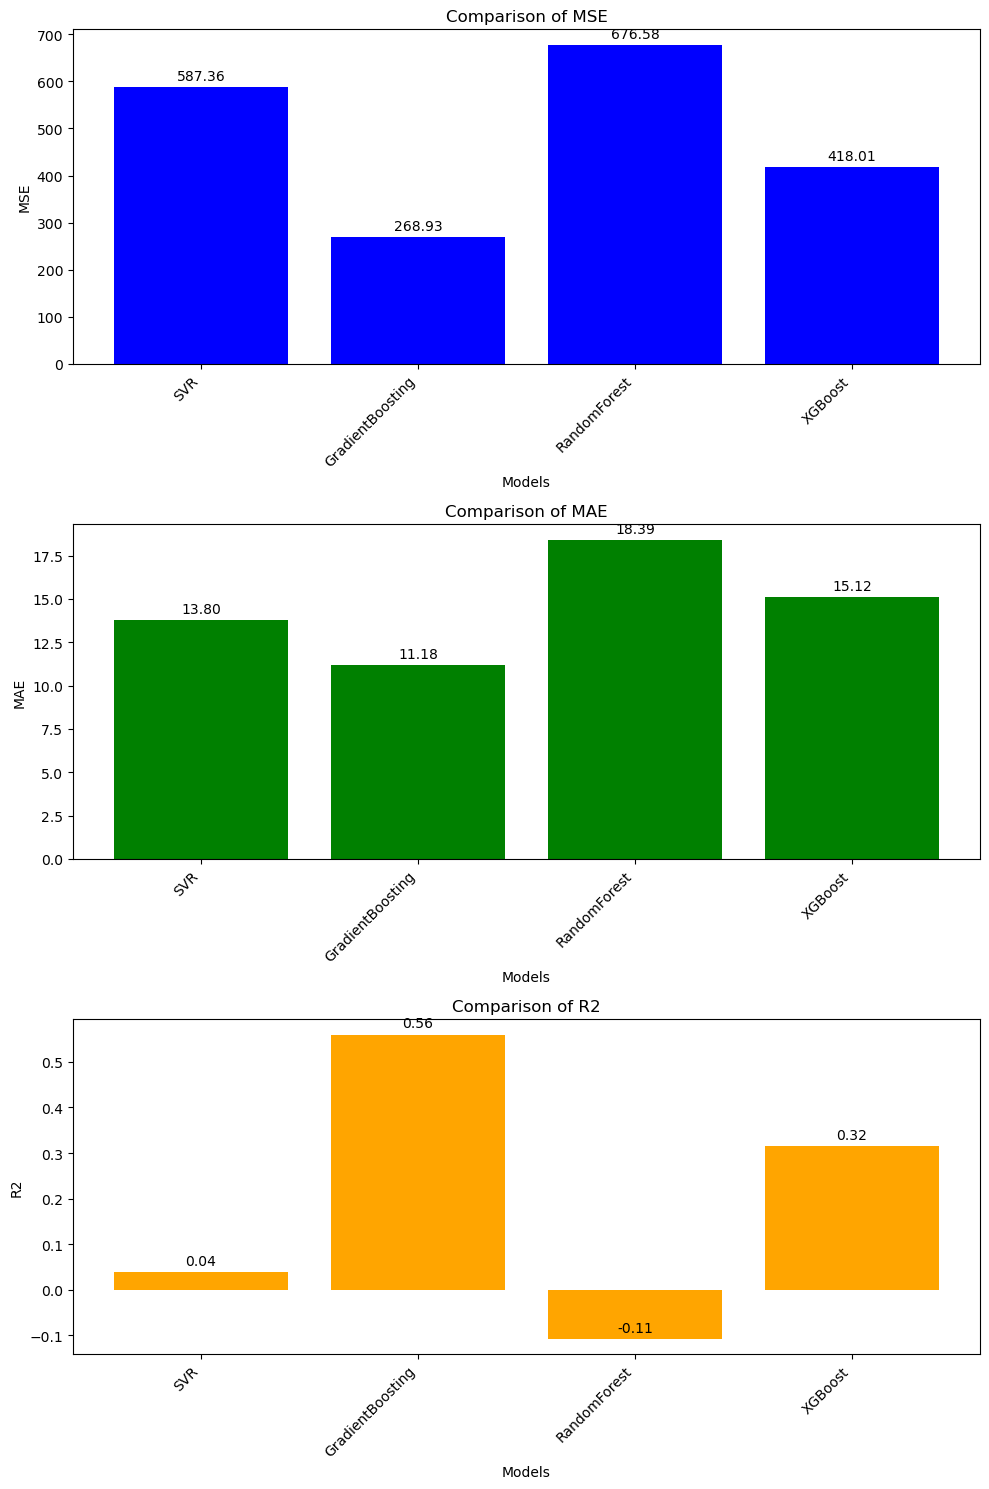

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Load the data
ardi_data = pd.read_csv("Cleaned_1_data.csv")

# Encode categorical variables once for all models
categorical_columns = ['LocationAbbr','Sex', 'ConditionType', 'Category','Cause_of_Death']
label_encoders = {col: LabelEncoder().fit(ardi_data[col]) for col in categorical_columns}
for col, le in label_encoders.items():
    ardi_data[col] = le.transform(ardi_data[col])

# Function to make predictions based on AgeGroup
def predict_by_agegroup(age_group, model):
    df_filtered = ardi_data[ardi_data['AgeGroup'] == age_group]
    
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['LocationAbbr','Sex', 'ConditionType', 'Category','Cause_of_Death']]
    y = df_filtered['Data_Value_Alt']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, r2

# Define models
models = {
    "SVR": SVR(kernel='linear'),
    "GradientBoosting": GradientBoostingRegressor(),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}

# Choose an age group for example
age_group = 'Under 21'

# Initialize metrics storage
results = {}

# Iterate over models and compute metrics
for model_name, model in models.items():
    mse, mae, r2 = predict_by_agegroup(age_group, model)
    results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Plotting
import matplotlib.pyplot as plt

# Assuming 'results' is your dictionary with the model comparison data

metrics = ['MSE', 'MAE', 'R2']
colors = ['blue', 'green', 'orange']

# Adjust the subplot layout to have one row per plot
fig, ax = plt.subplots(3, 1, figsize=(10, 15))  # Change to 3 rows, 1 column

for i, metric in enumerate(metrics):
    bars = ax[i].bar(results.keys(), [results[model][metric] for model in results], color=colors[i])
    ax[i].set_title(f'Comparison of {metric}')
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel('Models')

    # Annotate bars with the metric values
    for bar in bars:
        height = bar.get_height()
        ax[i].annotate(f'{height:.2f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')

    # Rotate x-axis labels for clarity
    ax[i].set_xticklabels(results.keys(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [3]:
# import joblib

# # Function to make predictions based on AgeGroup
# def predict_by_agegroup(age_group, model):
#     df_filtered = ardi_data[ardi_data['AgeGroup'] == age_group]
    
#     if len(df_filtered) < 2:
#         raise ValueError("Insufficient samples for training and testing.")
    
#     X = df_filtered[['LocationAbbr','Sex', 'ConditionType', 'Category','Cause_of_Death']]
#     y = df_filtered['Data_Value_Alt']
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     # Save the trained model
#     save_model(model, f'{age_group}_model.pkl')

#     return mse, mae, r2

# # Example function to save the model
# def save_model(model, filename):
#     joblib.dump(model, filename)

# # Define models
# models = {
#     "SVR": SVR(kernel='linear'),
#     "GradientBoosting": GradientBoostingRegressor(),
#     "RandomForest": RandomForestRegressor(),
#     "XGBoost": XGBRegressor()
# }

# # Choose an age group for example
# age_group = 'Under 21'

# # Initialize metrics storage
# results = {}

# # Iterate over models and compute metrics
# for model_name, model in models.items():
#     mse, mae, r2 = predict_by_agegroup(age_group, model)
#     results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# # Plotting code remains unchanged


In [4]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# from sklearn.svm import SVR
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# from xgboost import XGBRegressor
# import joblib

# # Load the trained models from saved files
# svr_model = joblib.load("SVR_model.pkl")
# gb_model = joblib.load("GradientBoosting_model.pkl")
# rf_model = joblib.load("RandomForest_model.pkl")
# xgb_model = joblib.load("XGBoost_model.pkl")

# # Load the data
# ardi_data = pd.read_csv("Cleaned_1_data.csv")

# # Encode categorical variables
# categorical_columns = ['LocationAbbr', 'ConditionType', 'Category', 'Cause_of_Death', 'Sex']
# label_encoders = {col: LabelEncoder().fit(ardi_data[col]) for col in categorical_columns}

# # Define a function to preprocess user input data
# def preprocess_user_input(location_abbr, sex, condition_type, category, cause_of_death):
#     # Capitalize or convert user input to uppercase where needed
#     location_abbr = location_abbr.upper()
#     sex = sex.capitalize()
#     condition_type = condition_type.capitalize()
#     category = category.capitalize()
#     cause_of_death = cause_of_death.capitalize()
    
#     # Encode categorical variables
#     encoded_features = {}
#     for col in categorical_columns:
#         encoded_features[col] = label_encoders[col].transform([locals()[col]])[0]
    
#     # Create a DataFrame with user input
#     user_input = pd.DataFrame(encoded_features, index=[0])
    
#     return user_input

# # Function to make ensemble predictions
# def ensemble_prediction(filtered_data, user_input):
#     # Make predictions using each model
#     svr_prediction = svr_model.predict(user_input)
#     gb_prediction = gb_model.predict(user_input)
#     rf_prediction = rf_model.predict(user_input)
#     xgb_prediction = xgb_model.predict(user_input)
    
#     # Aggregate predictions from all models
#     ensemble_pred = np.mean([svr_prediction, gb_prediction, rf_prediction, xgb_prediction])
    
#     return ensemble_pred

# # Function to interactively ask for user input and make predictions
# def predict_deaths():
#     # Ask for user input
#     age_group = input("Enter age group: ")
#     location_abbr = input("Enter location abbreviation: ")
#     sex = input("Enter sex: ")
#     condition_type = input("Enter condition type: ")
#     category = input("Enter category: ")
#     cause_of_death = input("Enter cause of death: ")
    
#     # Filter data based on user input age group
#     filtered_data = ardi_data[ardi_data['AgeGroup'] == age_group]
    
#     # Preprocess user input (excluding age group)
#     user_input = preprocess_user_input(location_abbr, sex, condition_type, category, cause_of_death)
    
#     # Make ensemble prediction
#     ensemble_pred = ensemble_prediction(filtered_data, user_input)
    
#     return ensemble_pred

# # Example usage
# predicted_deaths = predict_deaths()
# print("Predicted average number of deaths for the next 5 years:", predicted_deaths)


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import joblib

# Load the trained models from saved files
svr_model = joblib.load("SVR_model.pkl")
gb_model = joblib.load("GradientBoosting_model.pkl")
rf_model = joblib.load("RandomForest_model.pkl")
xgb_model = joblib.load("XGBoost_model.pkl")

# Load the data
ardi_data = pd.read_csv("Cleaned_1_data.csv")

# Encode categorical variables
categorical_columns = ['LocationAbbr', 'ConditionType', 'Category', 'Cause_of_Death', 'Sex']
label_encoders = {col: LabelEncoder().fit(ardi_data[col]) for col in categorical_columns}

# Define a function to preprocess user input data
# Function to preprocess user input with correct feature order
def preprocess_user_input(location_abbr, sex, condition_type, category, cause_of_death):
    #def preprocess_user_input(location_abbr, sex, condition_type, category, cause_of_death):
    try:
        # Capitalize or convert user input to uppercase where needed
        location_abbr = location_abbr.upper()
        sex = sex.capitalize()
        condition_type = condition_type.capitalize()
        category = category.capitalize()
        cause_of_death = cause_of_death.capitalize()

        # Encode categorical variables
        encoded_features = {}
        for col in categorical_columns:
            encoded_features[col] = label_encoders[col].transform([locals()[col]])[0]

        # Create a DataFrame with user input
        user_input = pd.DataFrame(encoded_features, index=[0])

        return user_input
    except KeyError as e:
        print("KeyError:", e)
        print("Please check your input and try again.")
        return None


# Function to make ensemble predictions
def ensemble_prediction(filtered_data, user_input):
    # Make predictions using each model
    svr_prediction = svr_model.predict(user_input)
    gb_prediction = gb_model.predict(user_input)
    rf_prediction = rf_model.predict(user_input)
    xgb_prediction = xgb_model.predict(user_input)
    
    # Aggregate predictions from all models
    ensemble_pred = np.mean([svr_prediction, gb_prediction, rf_prediction, xgb_prediction])
    
    return ensemble_pred

# Function to interactively ask for user input and make predictions
def predict_deaths():
    # Ask for user input
    age_group = input("Enter age group: ")
    location_abbr = input("Enter location abbreviation: ")
    sex = input("Enter sex: ")
    condition_type = input("Enter condition type: ")
    category = input("Enter category: ")
    cause_of_death = input("Enter cause of death: ")
    
    # Filter data based on user input age group
    filtered_data = ardi_data[ardi_data['AgeGroup'] == age_group]
    
    # Preprocess user input (excluding age group)
    user_input = preprocess_user_input(location_abbr, sex, condition_type, category, cause_of_death)
    
    # Make ensemble prediction
    ensemble_pred = ensemble_prediction(filtered_data, user_input)
    
    return ensemble_pred

# Example usage
predicted_deaths = predict_deaths()
print("Predicted average number of deaths for the next 5 years:", predicted_deaths)


Enter age group:  under 21
Enter location abbreviation:  al
Enter sex:  male
Enter condition type:  chronic
Enter category:  total
Enter cause of death:  alcohol abuse


KeyError: 'LocationAbbr'
Please check your input and try again.


C:\Users\adedi\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [8]:
user_input

NameError: name 'user_input' is not defined

In [6]:
X

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,ConditionType,Category,Cause_of_Death,Effect,ConsumptionPattern,Sex,AgeGroup,AgeGroup_Cat
0,2015,2019,49,48,0,1,9,39,0,1,0,5,4
1,2015,2019,49,48,0,2,9,39,0,1,0,5,4
4,2015,2019,49,48,0,0,9,39,0,0,1,5,4
5,2015,2019,49,48,0,1,9,39,0,0,1,5,4
6,2015,2019,49,48,0,2,9,39,0,0,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62499,2015,2019,50,50,0,1,9,39,0,0,2,4,3
62500,2015,2019,50,50,0,2,9,39,0,0,2,4,3
62501,2015,2019,50,50,0,0,9,39,0,1,2,4,3
62502,2015,2019,50,50,0,1,9,39,0,1,2,4,3


In [ ]:
# Print column names in ardi_data
print("Columns in ardi_data:", ardi_data.columns)

# Print keys in label_encoders
print("Keys in label_encoders:", label_encoders.keys())


## Location

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

# Read the data
ardi_data = pd.read_csv("Cleaned_1_data.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = ['AgeGroup', 'Sex', 'ConditionType', 'Category', 'Cause_of_Death']
for col in categorical_columns:
    le = LabelEncoder()
    ardi_data[col] = le.fit_transform(ardi_data[col])
    label_encoders[col] = le

# Function to make predictions based on LocationAbbr using Gradient Boosting
def predict_by_location_gb(location):
    df_filtered = ardi_data[ardi_data['LocationAbbr'] == location]
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    X = df_filtered[['AgeGroup', 'Sex', 'ConditionType', 'Category', 'Cause_of_Death']]
    y = df_filtered['Data_Value_Alt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_pred, mse, mae, r2

# Function to make predictions based on LocationAbbr using XGBoost
def predict_by_location_xgboost(location):
    df_filtered = ardi_data[ardi_data['LocationAbbr'] == location]
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    X = df_filtered[['AgeGroup', 'Sex', 'ConditionType', 'Category', 'Cause_of_Death']]
    y = df_filtered['Data_Value_Alt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_pred, mse, mae, r2

# Function to make predictions based on LocationAbbr using SVR
def predict_by_location_svr(location):
    df_filtered = ardi_data[ardi_data['LocationAbbr'] == location]
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    X = df_filtered[['AgeGroup', 'Sex', 'ConditionType', 'Category', 'Cause_of_Death']]
    y = df_filtered['Data_Value_Alt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Only include relevant features for SVR model training
    X_train_svr = X_train[['AgeGroup', 'Sex', 'ConditionType', 'Category', 'Cause_of_Death']]
    X_test_svr = X_test[['AgeGroup', 'Sex', 'ConditionType', 'Category', 'Cause_of_Death']]
    
    model = SVR(kernel='rbf')
    model.fit(X_train_svr, y_train)
    y_pred = model.predict(X_test_svr)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_pred, mse, mae, r2


# Function to make predictions based on LocationAbbr using Random Forest
def predict_by_location_random_forest(location):
    df_filtered = ardi_data[ardi_data['LocationAbbr'] == location]
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    X = df_filtered[['AgeGroup', 'Sex', 'ConditionType', 'Category', 'Cause_of_Death']]
    y = df_filtered['Data_Value_Alt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_pred, mse, mae, r2

# Example location for prediction
location = 'AL'

# Perform predictions for each model
gb_prediction, gb_mse, gb_mae, gb_r2 = predict_by_location_gb(location)
xgboost_prediction, xgboost_mse, xgboost_mae, xgboost_r2 = predict_by_location_xgboost(location)
svr_prediction, svr_mse, svr_mae, svr_r2 = predict_by_location_svr(location)
rf_prediction, rf_mse, rf_mae, rf_r2 = predict_by_location_random_forest(location)

#Train and save Gradient Boosting model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
joblib.dump(gb_model, "L_GradientBoosting_model.pkl")

# Train and save XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, "L_XGBoost_model.pkl")

# Train and save SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
joblib.dump(svr_model, "L_SVR_model.pkl")

# Train and save Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, "L_RandomForest_model.pkl")


# Plotting
models = [ 'SVR','Gradient Boosting', 'RandomForest', 'XGBoost']
mse_scores = [gb_mse, xgboost_mse, svr_mse, rf_mse]
mae_scores = [gb_mae, xgboost_mae, svr_mae, rf_mae]
r2_scores = [gb_r2, xgboost_r2, svr_r2, rf_r2]

# Define a function to plot each metric
def plot_metric(metric_scores, metric_name, color):
    plt.figure(figsize=(10, 5))  # Adjust figure size here as per your need
    bars = plt.bar(models, metric_scores, color=color)
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name} among Models using Location')
    # Add annotations to the bars
    for bar, score in zip(bars, metric_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')
    plt.show()


# Plot each metric in a separate row
plot_metric(mse_scores, 'Mean Squared Error (MSE)', 'blue')
plot_metric(mae_scores, 'Mean Absolute Error (MAE)', 'green')
plot_metric(r2_scores, 'R-squared (R2)', 'orange')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import joblib

# Load the trained models from saved files
svr_model = joblib.load("L_SVR_model.pkl")
gb_model = joblib.load("L_GradientBoosting_model.pkl")
rf_model = joblib.load("L_RandomForest_model.pkl")
xgb_model = joblib.load("L_XGBoost_model.pkl")

# Load the data
ardi_data = pd.read_csv("Cleaned_1_data.csv")

# Encode categorical variables
categorical_columns = ['ConditionType', 'Category', 'Cause_of_Death', 'Sex', 'AgeGroup']
label_encoders = {col: LabelEncoder().fit(ardi_data[col]) for col in categorical_columns}

# Define a function to preprocess user input data
def preprocess_user_input(location_abbr, sex, condition_type, category, cause_of_death, age_group):
    # Capitalize or convert user input to uppercase where needed
    sex = sex.capitalize()
    condition_type = condition_type.capitalize()
    category = category.capitalize()
    cause_of_death = cause_of_death.capitalize()
    
    # Encode categorical variables
    encoded_sex = label_encoders['Sex'].transform([sex])[0]
    encoded_condition_type = label_encoders['ConditionType'].transform([condition_type])[0]
    encoded_category = label_encoders['Category'].transform([category])[0]
    encoded_cause_of_death = label_encoders['Cause_of_Death'].transform([cause_of_death])[0]
    encoded_age_group = label_encoders['AgeGroup'].transform([age_group])[0]
    
    # Create a DataFrame with user input
    user_input = pd.DataFrame({
        'Sex': [encoded_sex],
        'ConditionType': [encoded_condition_type],
        'Category': [encoded_category],
        'Cause_of_Death': [encoded_cause_of_death],
        'AgeGroup': [encoded_age_group]
    })
    
    # Drop irrelevant columns
    user_input = user_input[['Sex', 'ConditionType', 'Category', 'Cause_of_Death', 'AgeGroup']]
    
    return user_input


# Function to make ensemble predictions
def ensemble_prediction(user_input):
    # Make predictions using each model
    svr_prediction = svr_model.predict(user_input)
    gb_prediction = gb_model.predict(user_input)
    rf_prediction = rf_model.predict(user_input)
    xgb_prediction = xgb_model.predict(user_input)
    
    # Aggregate predictions from all models
    ensemble_pred = np.mean([svr_prediction, gb_prediction, rf_prediction, xgb_prediction])
    
    return ensemble_pred

# Function to interactively ask for user input and make predictions
# Function to interactively ask for user input and make predictions
def predict_deaths():
    # Ask for user input
    location_abbr = input("Enter location abbreviation: ")
    sex = input("Enter sex: ")
    condition_type = input("Enter condition type: ")
    category = input("Enter category: ")
    cause_of_death = input("Enter cause of death: ")
    age_group = input("Enter age group: ")
    
    # Filter data based on user input location abbreviation
    filtered_data = ardi_data[ardi_data['LocationAbbr'] == location_abbr]
    
    # Ensure only the necessary columns are retained
    filtered_data = filtered_data[['Sex', 'ConditionType', 'Category', 'Cause_of_Death', 'AgeGroup']]
    
    # Preprocess user input
    user_input = preprocess_user_input(location_abbr, sex, condition_type, category, cause_of_death, age_group)
    
    # Make ensemble prediction
    ensemble_pred = ensemble_prediction(user_input)
    
    return ensemble_pred


# Example usage
predicted_deaths = predict_deaths()
print("Predicted average number of deaths for the next 5 years:", predicted_deaths)


In [ ]:
# Retrieve the feature names from the original dataset
expected_features = ardi_data.columns.tolist()

# Print the expected features
print("Features SVR is expecting:")
print(expected_features)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

ardi_data = pd.read_csv("Cleaned_1_data.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = ['AgeGroup', 'LocationAbbr', 'ConditionType', 'Category', 'Cause_of_Death']  # List of categorical columns to encode

for col in categorical_columns:
    le = LabelEncoder()
    ardi_data[col] = le.fit_transform(ardi_data[col])
    label_encoders[col] = le

# Function to make predictions based on Sex using SVR
def predict_by_sex_svr(sex):
    df_filtered = ardi_data[ardi_data['Sex'] == sex]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['AgeGroup', 'LocationAbbr', 'ConditionType', 'Category', 'Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = SVR(kernel='linear')  # Using a linear kernel for SVR
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    linear_mse = mean_squared_error(y_test, y_pred)
    linear_mae = mean_absolute_error(y_test, y_pred)
    linear_r2 = r2_score(y_test, y_pred)
    
    return y_pred, linear_mse, linear_mae, linear_r2

# Function to make predictions based on Sex using Gradient Boosting
def predict_by_sex_gb(sex):
    df_filtered = ardi_data[ardi_data['Sex'] == sex]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['AgeGroup', 'LocationAbbr', 'ConditionType', 'Category', 'Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingRegressor()  # Using GradientBoostingRegressor for regression
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    gb_mse = mean_squared_error(y_test, y_pred)
    gb_mae = mean_absolute_error(y_test, y_pred)
    gb_r2 = r2_score(y_test, y_pred)
    
    return y_pred, gb_mse, gb_mae, gb_r2

# Function to make predictions based on Sex using Random Forest
def predict_by_sex_rf(sex):
    df_filtered = ardi_data[ardi_data['Sex'] == sex]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['AgeGroup', 'LocationAbbr', 'ConditionType', 'Category', 'Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor()  # Using RandomForestRegressor for regression
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rf_mse = mean_squared_error(y_test, y_pred)
    rf_mae = mean_absolute_error(y_test, y_pred)
    rf_r2 = r2_score(y_test, y_pred)
    
    return y_pred, rf_mse, rf_mae, rf_r2

# Function to make predictions based on Sex using XGBoost
def predict_by_sex_xgb(sex):
    df_filtered = ardi_data[ardi_data['Sex'] == sex]
    
    # Check if there are enough samples for splitting
    if len(df_filtered) < 2:
        raise ValueError("Insufficient samples for training and testing.")
    
    X = df_filtered[['AgeGroup', 'LocationAbbr', 'ConditionType', 'Category', 'Cause_of_Death']]  # Features
    y = df_filtered['Data_Value_Alt']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor()  # Using XGBoost for regression
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    xgb_mse = mean_squared_error(y_test, y_pred)
    xgb_mae = mean_absolute_error(y_test, y_pred)
    xgb_r2 = r2_score(y_test, y_pred)
    
    return y_pred, xgb_mse, xgb_mae, xgb_r2

# Example prediction using SVR based on Sex
sex = 'Male'
svr_prediction, svr_mse, svr_mae, svr_r2 = predict_by_sex_svr(sex)
# print(f"SVR Predicted values for '{sex}':", svr_prediction)
# print("Mean Squared Error (MSE):", svr_mse)
# print("Mean Absolute Error (MAE):", svr_mae)
# print("R-squared (R2):", svr_r2)

# Example prediction using Gradient Boosting based on Sex
gb_prediction, gb_mse, gb_mae, gb_r2 = predict_by_sex_gb(sex)
# print(f"Gradient Boosting Predicted values for '{sex}':", gb_prediction)
# print("Mean Squared Error (MSE):", gb_mse)
# print("Mean Absolute Error (MAE):", gb_mae)
# print("R-squared (R2):", gb_r2)

# Example prediction using Random Forest based on Sex
rf_prediction, rf_mse, rf_mae, rf_r2 = predict_by_sex_rf(sex)
# print(f"Random Forest Predicted values for '{sex}':", rf_prediction)
# print("Mean Squared Error (MSE):", rf_mse)
# print("Mean Absolute Error (MAE):", rf_mae)
# print("R-squared (R2):", rf_r2)

# Example prediction using XGBoost based on Sex
xgb_prediction, xgb_mse, xgb_mae, xgb_r2 = predict_by_sex_xgb(sex)
# print(f"XGBoost Predicted values for '{sex}':", xgb_prediction)
# print("Mean Squared Error (MSE):", xgb_mse)
# print("Mean Absolute Error (MAE):", xgb_mae)
# print("R-squared (R2):", xgb_r2)

# Plotting

# Create a list of model names and their respective metrics
models = ['SVR', 'Gradient Boosting', 'Random Forest', 'XGBoost']
mse_scores = [svr_mse, gb_mse, rf_mse, xgb_mse]
mae_scores = [svr_mae, gb_mae, rf_mae, xgb_mae]
r2_scores = [svr_r2, gb_r2, rf_r2, xgb_r2]

# Plot Mean Squared Error (MSE)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, mse_scores, color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) among Models using Sex')

# Add annotations to the bars
for bar, mse in zip(bars, mse_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mse:.2f}', ha='center', va='bottom')

plt.show()

# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, mae_scores, color='green')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Mean Absolute Error (MAE) among Models using Sex')

# Add annotations to the bars
for bar, mae in zip(bars, mae_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mae:.2f}', ha='center', va='bottom')

plt.show()

# Plot R-squared (R2)
plt.figure(figsize=(10, 5))
bars = plt.bar(models, r2_scores, color='orange')
plt.xlabel('Models')
plt.ylabel('R-squared (R2)')
plt.title('Comparison of R-squared (R2) among Models using Sex')

# Add annotations to the bars
for bar, r2 in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{r2:.2f}', ha='center', va='bottom')

plt.show()
